<a href="https://colab.research.google.com/github/mingcv/Bread/blob/main/Bread.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install kornia
import argparse
import os
import PIL.Image as Image
import imageio
import kornia
import torch
import numpy as np
import torchvision.transforms.functional as TF
import torch.nn.functional as F
from tqdm import tqdm
from torch import nn
import cv2
import urllib.request as request;


# Load some scripts from remote.
exec(request.urlopen('https://github.com/mingcv/Bread_Colab/raw/main/colab_utils.py').read(), globals())
exec(request.urlopen(locate_resource('networks.py')).read(), globals())

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Download trained model weights from remote.
download_url_to_file(locate_resource('checkpoints/IANet_335.pth'))
download_url_to_file(locate_resource('checkpoints/NSNet_422.pth'))
download_url_to_file(locate_resource('checkpoints/FuseNet_CA_MEF_251.pth'))
download_url_to_file(locate_resource('checkpoints/FuseNet_FD_297.pth'))

100%|██████████| 3.25M/3.25M [00:00<00:00, 205MB/s]
100%|██████████| 3.25M/3.25M [00:00<00:00, 192MB/s]
100%|██████████| 874k/874k [00:00<00:00, 124MB/s]
100%|██████████| 872k/872k [00:00<00:00, 96.7MB/s]


In [ ]:

# Defination of the Bread Framework.
class ModelBreadNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.eps = 1e-6
        self.model_ianet = IAN(in_channels=1, out_channels=1)
        self.model_nsnet = ANSN(in_channels=2, out_channels=1)
        self.model_canet = FuseNet(in_channels=4, out_channels=2)

        self.load_weight(self.model_ianet, './IANet_335.pth')
        self.load_weight(self.model_nsnet, './NSNet_422.pth')
        self.load_weight(self.model_canet, './FuseNet_CA_MEF_251.pth')

    def load_weight(self, model, weight_pth):
        if model is not None:
            state_dict = torch.load(weight_pth)
            ret = model.load_state_dict(state_dict, strict=True)
            print(ret)

    def noise_syn_exp(self, illumi, strength):
        return torch.exp(-illumi) * strength

    def forward(self, image, gamma=1., strength=0.1):
        # Color space mapping
        texture_in, cb_in, cr_in = torch.split(kornia.color.rgb_to_ycbcr(image), 1, dim=1)

        # Illumination prediction
        texture_in_down = F.interpolate(texture_in, scale_factor=0.5, mode='bicubic', align_corners=True)
        texture_illumi = self.model_ianet(texture_in_down)
        texture_illumi = F.interpolate(texture_illumi, scale_factor=2, mode='bicubic', align_corners=True)

        # Illumination adjustment
        texture_illumi = torch.clamp(texture_illumi ** gamma, 0., 1.)
        texture_ia = texture_in / torch.clamp_min(texture_illumi, self.eps)
        texture_ia = torch.clamp(texture_ia, 0., 1.)

        # Noise suppression and fusion
        attention = self.noise_syn_exp(texture_illumi, strength)
        texture_res = self.model_nsnet(torch.cat([texture_ia, attention], dim=1))
        texture_ns = texture_ia + texture_res

        # Further preserve the texture under brighter illumination
        texture_ns = texture_illumi * texture_in + (1 - texture_illumi) * texture_ns
        texture_ns = torch.clamp(texture_ns, 0, 1)

        # Color adaption
        colors = self.model_canet(
            torch.cat([texture_in, cb_in, cr_in, texture_ns], dim=1))
        cb_out, cr_out = torch.split(colors, 1, dim=1)
        cb_out = torch.clamp(cb_out, 0, 1)
        cr_out = torch.clamp(cr_out, 0, 1)

        # Color space mapping
        image_out = kornia.color.ycbcr_to_rgb(
            torch.cat([texture_ns, cb_out, cr_out], dim=1))

        # Further preserve the color under brighter illumination
        img_fusion = texture_illumi * image + (1 - texture_illumi) * image_out
        _, cb_fuse, cr_fuse = torch.split(kornia.color.rgb_to_ycbcr(img_fusion), 1, dim=1)
        image_out = kornia.color.ycbcr_to_rgb(
            torch.cat([texture_ns, cb_fuse, cr_fuse], dim=1))
        image_out = torch.clamp(image_out, 0, 1)

        # outputs: texture_ia, texture_ns, image_out, texture_illumi, texture_res
        return image_out

model = ModelBreadNet().eval().cuda()

<All keys matched successfully>
<All keys matched successfully>
<All keys matched successfully>


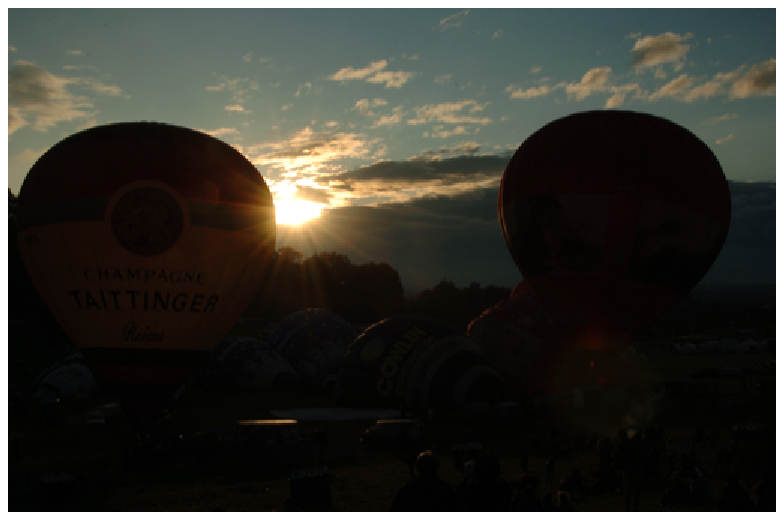

In [ ]:
# Load image from a url and convert it into pytorch tensor
im = imageio.imread(locate_resource("images/Balloons.png"))
im = size_round(im)
imshow(im)

im_in = numpy_to_tensor(im).cuda()

In [ ]:
# Upload Your Own Image Here!
from ipywidgets import FileUpload
import io

def load_and_show_image(image):
  global im_in
  image = size_round(image)[...,:3]
  imshow(image)
  im_in = numpy_to_tensor(image).cuda()

def on_upload_change(e):
  obj = e['owner'].value
  content = obj[list(obj.keys())[0]]['content']
  im = Image.open(io.BytesIO(content))
  im = np.array(im)
  load_and_show_image(im)


uploader = FileUpload(accept='image/*')

display(uploader)

uploader.observe(on_upload_change, names='_counter')

In [ ]:
from ipywidgets import interact, FloatSlider
from ipywidgets import HTML
from IPython.display import display
import base64

btn_dl = '''<html>
<head>
<meta name="viewport" content="width=device-width, initial-scale=1">
</head>
<body>
<a download="{filename}" href="data:image/png;base64,{payload}" download>
<button class="p-Widget jupyter-widgets jupyter-button widget-button mod-warning">Download File</button>
</a>
</body>
</html>
'''


def filtering(gamma=1.0, strength=0.1):  
    im_adj = model(im_in, gamma, strength)
    im_adj = tensor_to_numpy(im_adj)

    _, buffer = cv2.imencode('.png',cv2.cvtColor(im_adj,cv2.COLOR_RGB2BGR))
    im_base64 = base64.b64encode(buffer)
    im_base64 = im_base64.decode()
    display(HTML(btn_dl.format(payload=im_base64,filename='output.png')))

    imshow(im_adj)



interact(filtering, 
     gamma=FloatSlider(min=0., max=1.5, step=0.1, value=1.0, continuous_update=True),    # gamma correction for the resulting illumination
     strength=FloatSlider(min=0., max=0.2, step=0.01, value=0.05, continuous_update=True)); # controlling the denoising strength

interactive(children=(FloatSlider(value=1.0, description='gamma', max=1.5), FloatSlider(value=0.05, descriptio…